## 1. Packages & Initializations

In [152]:
from flask import Flask, request, jsonify, render_template, redirect, url_for, session
from flask_sqlalchemy import SQLAlchemy
from werkzeug.security import check_password_hash, generate_password_hash
from abc import ABC, abstractmethod
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score
from itertools import product
import pickle
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta
import string
import random
import re

In [115]:
app = Flask(__name__)
# Configure the SQLAlchemy part of the app instance
app.config['SQLALCHEMY_DATABASE_URI'] = 'sqlite:///aidea.db'
app.config['SQLALCHEMY_TRACK_MODIFICATIONS'] = False
app.secret_key = 'Doggan98-ddd'
# Create the SQLAlchemy db instance
db = SQLAlchemy(app)

## 2. Models

### 2.0 Model Class Abstraction

In [261]:
class Model(ABC):
    def __init__(self, data, volume, symbol_name):
        self.data = data
        self.volume = volume
        self.symbol_name = symbol_name

    @abstractmethod
    def train(self):
        """
        Abstract method to train the model.
        """
        pass
    
    @abstractmethod
    def forecast(self, forecast_days):
        """
        Abstract method to make predictions using the trained model.
        """
        pass

### 2.1 AR Model

In [291]:
class AR_model(Model):
    def __init__(self, data, symbol_name):
        super().__init__(data = data['Close'], volume = data['Volume'], symbol_name = symbol_name)
        self.trained_model = None
        self.model_type = 'Auto Regressive'

    def check_stationarity(self, series, alpha=0.05):
        series = series.dropna()
        result = adfuller(series)
        p_value = result[1]
        return p_value < alpha

    def log_transform(self, series):
        return np.log(series).dropna()
    
    def train(self):
        # Handle NaNs
        data = self.data.dropna()

        # Check stationarity and apply log transformation if needed
        if not self.check_stationarity(data):
            print("Series is not stationary. Applying log transformation...")
            data= self.log_transform(data)
                
        # Define parameter grid for tuning
        trends = ['n', 'c', 't', 'ct']
        min_lag = 1
        max_lag = int(np.sqrt(len(data))) if len(data) >= 20 else len(data) // 2  # Ensure a practical upper bound for small datasets
        lags_range = range(min_lag, max_lag + 1) 

        best_r2 = -float('inf') 
        best_params = None

        # Perform grid search with cross-validation on the training set
        # Choose the best params based on R2 score
        n_splits = 3
        tscv = TimeSeriesSplit(n_splits=n_splits)  # Time series cross-validation
        warnings.filterwarnings("ignore")
        for trend, lags in product(trends, lags_range):
            r2_sum = 0
            for train_index, val_index in tscv.split(data):
                train_split, val_split = data.iloc[train_index], data.iloc[val_index]
                try:
                    model = AutoReg(train_split.values, lags=lags, trend=trend).fit()
                    predictions = model.predict(start=len(train_split), end=len(train_split) + len(val_split) - 1)
                    r2 = r2_score(val_split, predictions)
                    r2_sum += r2
                except Exception as e:
                    print(f"Error for trend={trend}, lags={lags}: {e}")
                    continue
            
            # Average R2 score across folds
            avg_r2 = r2_sum / n_splits
            
            # Update best parameters if better R2 found
            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_params = (trend, lags)

        best_trend, best_lags = best_params
        
        print(f"Best R2 score: {best_r2:.4f}")
        print(f"Best parameters: trend={best_trend}, lags={best_lags}")
        
        # Fit the best model on the entire dataset 
        try:
            self.trained_model = AutoReg(data.values, lags=best_lags, trend=best_trend).fit()
        except Exception as e:
            print(f'Model training failed with the error message: {e}')
        
        return self.trained_model
    
    def forecast(self, forecast_days):
        #Forecast next forecast_period days
        start = len(self.data)
        end = start + forecast_days - 1
        forecast_prices = self.trained_model.predict(start=start, end=end)

       # Optional: Reverse log transformation if applied
        if self.data.apply(lambda x: x > 0).all():
            forecast_prices = np.exp(forecast_prices)

        # Plot the data
        # Create date range for forecasted data
        forecast_dates = pd.date_range(start=self.data.index[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')

        # Create figure and axis
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(14, 7), gridspec_kw={'height_ratios': [3, 1]})

        # Plot the price data
        ax1.plot(self.data.index, self.data, label='Historical Data', color='black')
        ax1.plot(forecast_dates, forecast_prices, label='Forecasted Prices', color='red')
        ax1.set_title(f'Model: {self.model_type} \n Symbol: {self.symbol_name}', weight = 'bold')
        ax1.set_ylabel('Close Price', weight = 'bold')
        ax1.legend(loc='upper left')
        ax1.grid(True)

        # Plot the volume data
        volume_colors = np.where(self.data.diff() >= 0, 'green', 'red')
        ax2.bar(self.data.index, self.volume, color=volume_colors, alpha=0.6)
        ax2.set_ylabel('Volume', weight = 'bold')
        ax2.set_xlabel('Date', weight = 'bold')
        ax2.grid(True)

        # Show plot
        fig.tight_layout()
        plt.show()

        '''
        # Save the plot to a BytesIO object
        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close()

        # Return the plot as a base64-encoded string
        return base64.b64encode(buf.getvalue()).decode('utf-8')
        '''



In [295]:
symbol_name = 'GSRAY.IS'
data_length = 365
forecast_days = 30
now = datetime.now()
start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
end_date = now.strftime("%Y-%m-%d")
data = fetch_data(symbol_name, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed

In [296]:
ar_model = AR_model(data=data, symbol_name = symbol_name)

In [297]:
ar_model.train()

Series is not stationary. Applying log transformation...
Best R2 score: -1.3126
Best parameters: trend=c, lags=1


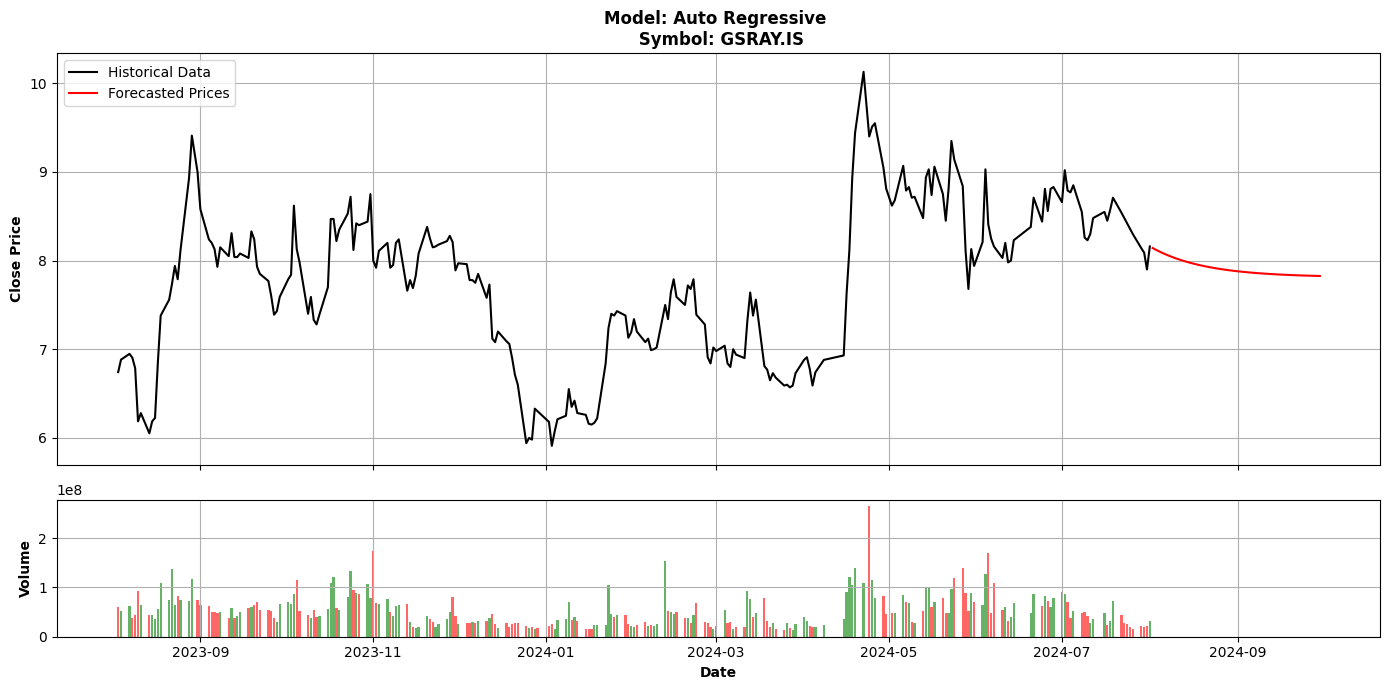

In [298]:
ar_model.forecast(forecast_days = 60)

### Model Creation Method

In [118]:
def create_model(model_type, data):
    if model_type == 'AR':
        return AR_model(data)

## 3. Database for User and Model Tables

### 3.1 Users Table

In [119]:
class User(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    email = db.Column(db.String(120), unique=True, nullable=False)
    password = db.Column(db.String(255), nullable=False)
    account_type = db.Column(db.String(20), nullable=False)  # 'basic' or 'premium'
    symbols = db.relationship('Symbol', backref='user', lazy=True)

    def __repr__(self):
        return f'<User {self.email}>'

### 3.2 Symbols Table

In [120]:
class Symbol(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    name = db.Column(db.String(50), nullable=False, unique=True)
    user_id = db.Column(db.Integer, db.ForeignKey('user.id'), nullable=False)

    def __repr__(self):
        return f'<Symbol {self.name}>'

### 3.3 Trained Models Table

In [121]:
class TrainedModels(db.Model):
    id = db.Column(db.Integer, primary_key=True, autoincrement=True)
    symbol = db.Column(db.String(20), nullable=False)
    model_type = db.Column(db.String(50), nullable=False)
    start_date = db.Column(db.String(50), nullable=False)
    end_date = db.Column(db.String(50), nullable=False)  # Nullable if model is ongoing
    trained_model = db.Column(db.Text)  # Serialized model data or file path

    def save_trained_model(self, trained_model):
        """
        Save the trained model to the database.
        """
        self.trained_model = pickle.dumps(trained_model)
        db.session.commit()
    
    def load_trained_model(self, model_type, start_date, end_date, symbol):
        model = TrainedModels.query.filter_by(
                    model_type=model_type,
                    start_date=start_date,
                    end_date=end_date,
                    symbol=symbol
                ).first()
        if model:
            return pickle.loads(model.trained_model)
        else:
            return None

### 3.4 Temporary Password

In [122]:
class TemporaryPassword(db.Model):
    email = db.Column(db.String(120), primary_key=True, nullable=False)
    temp_password = db.Column(db.String(255), nullable=False)

## 4. PAGES

In [123]:
@app.route('/')
def index():
    return render_template('login.html')

### 4.1 Login 

In [124]:
@app.route('/login', methods=['GET', 'POST'])
def login():

    if request.method == 'GET':
        # Serve the signup and forgot password page
        return render_template('login.html')
    
    if request.method == 'POST':
        data = request.json
        email = data.get('email')
        password = data.get('password')
        
        user = User.query.filter_by(email=email).first()

        if user and check_password_hash(user.password, password):
            # Store user ID in session
            session['user_id'] = user.id
            return jsonify({'message': 'Login successful!', 'redirect': url_for('main')}), 200
        else:
            return jsonify({'message': 'Invalid credentials'}), 401

### 4.2 Signup

In [125]:
def is_valid_password(password):
    """Check if the password is valid based on the criteria."""
    if len(password) < 8: # Check password length
        return False
    if not re.search(r'[A-Z]', password):  # Check for uppercase letter
        return False
    if not re.search(r'[a-z]', password):  # Check for lowercase letter
        return False
    if not re.search(r'[0-9]', password):  # Check for number
        return False
    return True

In [126]:
@app.route('/signup', methods=['GET', 'POST'])
def signup():
    if request.method == 'GET':
        # Serve the signup page
        return render_template('signup.html')
    
    if request.method == 'POST':
        data = request.json
        if not data:
            return jsonify({'message': 'No data provided'}), 400
        
        email = data.get('email')
        password = data.get('password')
        password_re = data.get('password_re')
        
        print('here')
        # Check if all fields are present
        if not email or not password or not password_re:
            return jsonify({'message': 'All fields are required.'}), 400

        # Check if email already exists
        existing_user = User.query.filter_by(email=email).first()
        if existing_user:
            return jsonify({'message': 'User already exists.'}), 400

        # Check if passwords match
        if password != password_re:
            return jsonify({'message': 'Passwords do not match.'}), 400
        
        # Validate password strength
        if not is_valid_password(password):
            return jsonify({'message': 'Password must be at least 8 characters long, include uppercase letters, lowercase letters, and numbers.'}), 400
        
        # Create new user
        hashed_password = generate_password_hash(password, method='pbkdf2:sha256')

        print('here2')
        # Creating an empty list of symbols for the new user is implicit because we start with no symbols related to the user
        new_user = User(email=email, password=hashed_password, account_type='basic')
        print('here3')
        try:
            db.session.add(new_user)
            db.session.commit()
            print('here4')
            return jsonify({'message': 'Sign-up successful!', 'redirect': url_for('login')}), 200
        except Exception as e:
            print(e)
            return jsonify({'message': 'Error creating user.'}), 500


### 4.3 Request E-mail

In [127]:
def generate_temporary_password(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))

def send_email(email, temporary_password):
    # Placeholder function to simulate sending an email
    # Implement actual email sending logic here
    print(f"Sending temporary password to {email}: {temporary_password}")

In [128]:
@app.route('/request_email', methods=['GET', 'POST'])
def request_email():
    if request.method == 'POST':
        data = request.get_json()
        email = data.get('email')
        
        # Check if the email exists in the User database
        user = User.query.filter_by(email=email).first()
        if user:  
            # Generate a temporary password
            temp_password = generate_temporary_password()
            # Check if a temporary password entry already exists for the email
            temp_password_entry = TemporaryPassword.query.filter_by(email=email).first()
            if temp_password_entry:
                db.session.delete(temp_password_entry)
                db.session.commit()

            temp_password_entry = TemporaryPassword(email=email, temp_password=temp_password)
            db.session.add(temp_password_entry)
            db.session.commit()
            
            # Send a temporary password
            send_email(email, temp_password)

            # Store the email in a session to use in forgot password section
            session['resetEmail'] = email
            
            return jsonify({'success': True, 'message': 'Temporary password sent to your email'})
        else:
            return jsonify({'success': False, 'message': 'Email not found'})

    return render_template('request_email.html')


### 4.4 Forgot Passward

In [129]:
@app.route('/forgot_password', methods=['GET', 'POST'])
def forgot_password():
    if request.method == 'POST':
        data = request.get_json()
        temp_password = data.get('tempPassword')
        
        #Retrieve email from session
        email = session.get('resetEmail')

        if not email:
            return jsonify({'success': False, 'message': 'No email found in session. Please request an email first.'})

        # Check the temporary password in the database
        temp_password_entry = TemporaryPassword.query.filter_by(email=email, temp_password=temp_password).first()
        if temp_password_entry:
            # Temporary password matches
            return jsonify({'success': True, 'message': 'Temporary password verified. Proceed to reset password.'})
        else:
            return jsonify({'success': False, 'message': 'Invalid temporary password'})

    return render_template('forgot_password.html')

### 4.5 Reset Password

In [130]:
@app.route('/reset_password', methods=['GET', 'POST'])
def reset_password():
    if request.method == 'POST':
        data = request.get_json()
        new_password = data.get('newPassword')
        new_password_re = data.get('newPassword_re')

        # Retrieve the email from session
        email = session.get('resetEmail')

        if not email:
            return jsonify({'success': False, 'message': 'No email found in session. Please request an email first.'})

        if new_password != new_password_re:
            return jsonify({'success': False, 'message': 'Passwords do not match'})
        
        # Validate password strength
        if not is_valid_password(new_password):
            return jsonify({'message': 'Password must be at least 8 characters long, include uppercase letters, lowercase letters, and numbers.'}), 400

        # Fetch the user from the database
        user = User.query.filter_by(email=email).first()
        if user:
            # Check if the new password is different from the current password
            if check_password_hash(user.password, new_password):
                return jsonify({'success': False, 'message': 'New password must be different from the old password'})
            
            # Update the password
            hashed_new_password = generate_password_hash(new_password, method='pbkdf2:sha256')
            user.password = hashed_new_password
            db.session.commit()
            return jsonify({'success': True, 'message': 'Password successfully updated. You can now login with your new password.'})
        else:
            return jsonify({'success': False, 'message': 'User not found'})

    # Ensure session email is set, otherwise redirect to request_email
    if not session.get('resetEmail'):
        return jsonify({'redirect': '/request_email', 'message': 'No email found in session. Please request an email first.'})

    return render_template('reset_password.html')

### 4.6 Main 

In [131]:
@app.route('/main', methods=['GET', 'POST']) # Forecaster Button 
def main():
    # Data fetching
    return render_template('main.html')

In [132]:
@app.route('/logout', methods=['GET', 'POST']) # Logout Button
def logout():
    # Perform logout operations if needed
    return redirect(url_for('login'))

In [133]:
@app.route('/my_profile', methods=['GET', 'POST']) # My Profile Button
def my_profile():
    return render_template('my_profile.html')

In [134]:
@app.route('/about_models', methods=['GET', 'POST']) # About Models Button
def about_models():
    return render_template('about_models.html')

In [135]:
@app.route('/get_symbols', methods=['GET']) # Getter method to fetch symbols from the users account
def get_symbols():
    user_id = session.get('user_id')
    if not user_id:
        return jsonify({'success': False, 'message': 'User not logged in'}), 401

    symbols = Symbol.query.filter_by(user_id=user_id).all()
    symbol_list = [symbol.name for symbol in symbols]

    return jsonify({'symbols': symbol_list}), 200

In [141]:
def fetch_data(symbol, start_date, end_date): # fetch data based on user preference
    data = None
    try:
        # Fetch historical price data
        df = yf.download(symbol, start=start_date, end=end_date)

        # Drop 'Adj Close' column if present
        if 'Adj Close' in df.columns:
            df.drop(columns=['Adj Close'], inplace=True)

        # Store the dataframe with technical indicators
        data = df

    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

    return data

def check_symbol_existence(symbol): #check the existence of symbol from yahoo finance
    try:
        stock = yf.Ticker(symbol)
        data = stock.history(period="1d")
        return not data.empty
    except Exception as e:
        print(f"Error fetching data for symbol {symbol}: {e}")
        return False

In [137]:
@app.route('/add_symbol', methods=['POST'])
def add_symbol(): # add symbol to the db
    user_id = session.get('user_id')
    if not user_id:
        return jsonify({'success': False, 'message': 'User not logged in'}), 401

    data = request.json
    symbol_name = data.get('symbol')
    if not symbol_name:
        return jsonify({'success': False, 'message': 'Symbol name not provided'}), 400

    # Capitalize the symbol name
    symbol_name = symbol_name.upper()
    
    if not check_symbol_existence(symbol_name):
        return jsonify({'success': False, 'message': 'Symbol does not exist'}), 404

    existing_symbol = Symbol.query.filter_by(name=symbol_name, user_id=user_id).first()
    if existing_symbol:
        return jsonify({'success': False, 'message': 'Symbol already added'}), 400
    
    try:
        new_symbol = Symbol(name=symbol_name, user_id=user_id)
        db.session.add(new_symbol)
        db.session.commit()
    except Exception as e:
        return jsonify({'success': False, 'message': 'Database error: ' + str(e)}), 500


    return jsonify({'success': True}), 200

In [138]:
@app.route('/delete_symbol', methods=['POST'])
def delete_symbol(): # delete symbol from the db
    data = request.json
    if not data or 'symbol' not in data:
        return jsonify({'message': 'Invalid request'}), 400

    symbol_name = data['symbol']
    user_id = session.get('user_id')

    # Find and delete the symbol
    symbol = Symbol.query.filter_by(name=symbol_name, user_id=user_id).first()
    if symbol:
        db.session.delete(symbol)
        db.session.commit()
        return jsonify({'success': True}), 200
    else:
        return jsonify({'message': 'Symbol not found'}), 404

In [139]:
@app.route('/predict', methods=['GET', 'POST'])
def predict():
    try:
        data = request.json
        symbol = data['symbol']
        data_length = data['data_length']
        forecast_days = data['forecast_days']
        model_type = data['model_type']
    
        #Set start and end date
        now = datetime.now()
        start_date =  (now - timedelta(days = data_length)).strftime("%Y-%m-%d")
        end_date = now.strftime("%Y-%m-%d")

        #Check if model already exists
        model = TrainedModels.load_trained_model(model_type=model_type, start_date=start_date, end_date=end_date, symbol=symbol)
        forecast_prices = None
        if model:  # if the model is already trained avoid re-training it.
            trained_model = model
            # Forecast
            forecast_prices = trained_model.forecast(forecast_days = forecast_days)
        else:
            data = fetch_data(symbol, start_date, end_date)
            model = create_model(model_type, data)
            trained_model = model.train()
            # Create a new instance of Model
            new_model = TrainedModels(symbol= symbol, model_type= model_type, start_date= start_date, end_date= end_date)
            # Save the trained model to the database
            new_model.save_trained_model(trained_model)
            # Commit the changes
            db.session.add(new_model)
            db.session.commit()
            # Forecast
            forecast_prices = trained_model.forecast(forecast_days = forecast_days)

        # Example: Data to send to Firebase
        processed_data = {
            'forecast_prices': forecast_prices,
            'processed': True
        }

        return jsonify(processed_data), 200 

    except KeyError as e:
        return jsonify({'error': f'Missing key: {e.args[0]}'}, 400)

    except Exception as e:
        return jsonify({'error': str(e)}, 500)

### 4.7 My Profile

### 4.8 About Models

## 5 App Run

In [140]:
if __name__ == '__main__':
    with app.app_context():
        db.create_all()
    app.run(debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [02/Aug/2024 10:30:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:25] "POST /login HTTP/1.1" 401 -
127.0.0.1 - - [02/Aug/2024 10:30:41] "POST /login HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:41] "GET /main HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:41] "GET /get_symbols HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:48] "POST /delete_symbol HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:48] "GET /get_symbols HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:53] "POST /delete_symbol HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:53] "GET /get_symbols HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:54] "POST /delete_symbol HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:54] "GET /get_symbols HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:59] "POST /delete_symbol HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:30:59] "GET /get_symbols HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2024 10:31:00]